- Minecraft Version 1.21.5
- Seed: "vcpi"
- Gamerules: "doDaylightCycle=false" "doWeatherCycle=false" "doMobSpawning=false"
- Commands. /time set day
- render distance: 12

In [8]:
import time

from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

from src.dataset import PairedImageDataset
from src.plot_utils import show_image_pairs, show_test_results

cuda = torch.cuda.is_available()

device = torch.device("cuda" if cuda else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

full_dataset = PairedImageDataset("generator_bot/screenshots", transforms=transform)

dataset_size = len(full_dataset)
test_size = int(0.2 * dataset_size)
train_size = dataset_size - test_size

print(f"Total dataset size: {dataset_size}")
print(f"Train size: {train_size}")
print(f"Test size: {test_size}")

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

BATCH_SIZE = 4

train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=8)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=8)

print(f"Train batches: {len(train_dl)}")
print(f"Test batches: {len(test_dl)}")

Total dataset size: 3600
Train size: 2880
Test size: 720
Train batches: 720
Test batches: 180


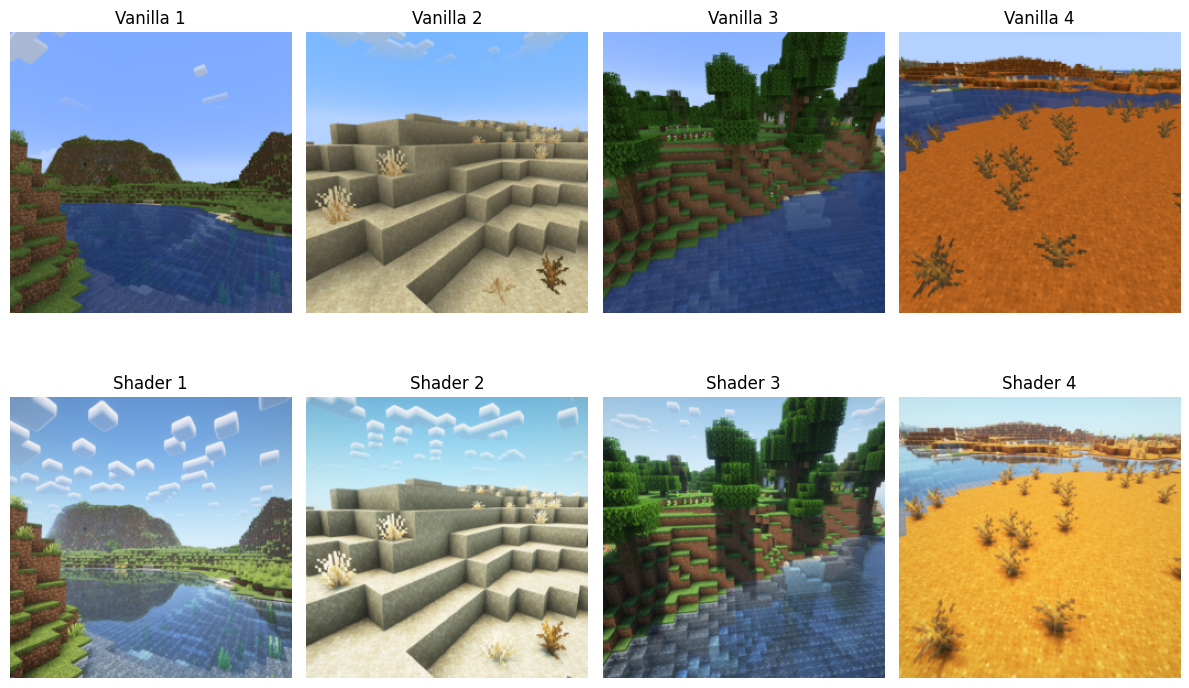

In [10]:
show_image_pairs(train_dl, num_pairs=4)

In [11]:
from src.models import GeneratorUNet, PatchDiscriminator, weights_init_normal

G = GeneratorUNet().to(device)
D = PatchDiscriminator().to(device)

G.apply(weights_init_normal)
D.apply(weights_init_normal)

g_opt = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
d_opt = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

gan_criterion = nn.BCEWithLogitsLoss()
l1_criterion = nn.L1Loss()

In [12]:
def train_epoch(dataloader, G, D, g_opt, d_opt, gan_crit, l1_crit, lambda_l1=100):
    G.train()
    D.train()

    total_discriminator_loss = 0
    total_generator_loss = 0

    num_batches = 0

    loop = tqdm(dataloader, leave=True, unit_scale=BATCH_SIZE, unit="pairs")

    for batch in loop:
        x = batch["vanilla"].to(device, non_blocking=True)
        y = batch["shader"].to(device, non_blocking=True)

        valid = torch.ones((x.size(0), 1, 16, 16), device=device)
        fake = torch.zeros_like(valid)

        # ---- Discriminator ----
        d_opt.zero_grad()
        # Real
        real_pred = D(x, y)
        d_real_loss = gan_crit(real_pred, valid)
        # Fake
        y_fake = G(x)
        fake_pred = D(x, y_fake.detach())
        d_fake_loss = gan_crit(fake_pred, fake)
        d_loss = (d_real_loss + d_fake_loss) * 0.5
        d_loss.backward()
        d_opt.step()

        # ---- Generator ----
        g_opt.zero_grad()
        # GAN loss
        fake_pred = D(x, y_fake)
        g_gan = gan_crit(fake_pred, valid)
        # Reconstruction loss
        g_l1 = l1_crit(y_fake, y) * lambda_l1
        g_loss = g_gan + g_l1
        g_loss.backward()
        g_opt.step()

        total_discriminator_loss += d_loss.item()
        total_generator_loss += g_loss.item()
        num_batches += 1

        loop.set_postfix(d_loss=total_discriminator_loss / num_batches, g_loss=total_generator_loss / num_batches, num_batches=num_batches)

    return total_discriminator_loss / num_batches, total_generator_loss / num_batches

In [13]:
from src.checkpoint_utils import save_checkpoint, load_checkpoint

prev_time = time.time()

EPOCHS = 3
CHECKPOINT_FREQUENCY = 10  # Save checkpoint every 10 epochs
LOAD_CHECKPOINT = 3  # Set to epoch number to load specific checkpoint, or None to start fresh

# Load checkpoint or start fresh
checkpoint_dir = "checkpoints"
if LOAD_CHECKPOINT is not None:
    start_epoch = load_checkpoint(LOAD_CHECKPOINT, G, D, g_opt, d_opt, device)
else:
    print("Starting training from scratch.")
    start_epoch = 0

for epoch in range(start_epoch, EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 50)

    # Train
    d_loss, g_loss = train_epoch(train_dl, G, D, g_opt, d_opt, gan_criterion, l1_criterion)

    print(f"Train - D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

    current_time = time.time()
    elapsed = current_time - prev_time
    print(f"Time elapsed: {elapsed:.2f}s")
    prev_time = current_time

    if (epoch + 1) % CHECKPOINT_FREQUENCY == 0 or epoch == EPOCHS - 1:
        save_checkpoint(epoch, G, D, g_opt, d_opt)

Loading checkpoint: checkpoints\checkpoint_epoch_3.pth


Results on Test Set:


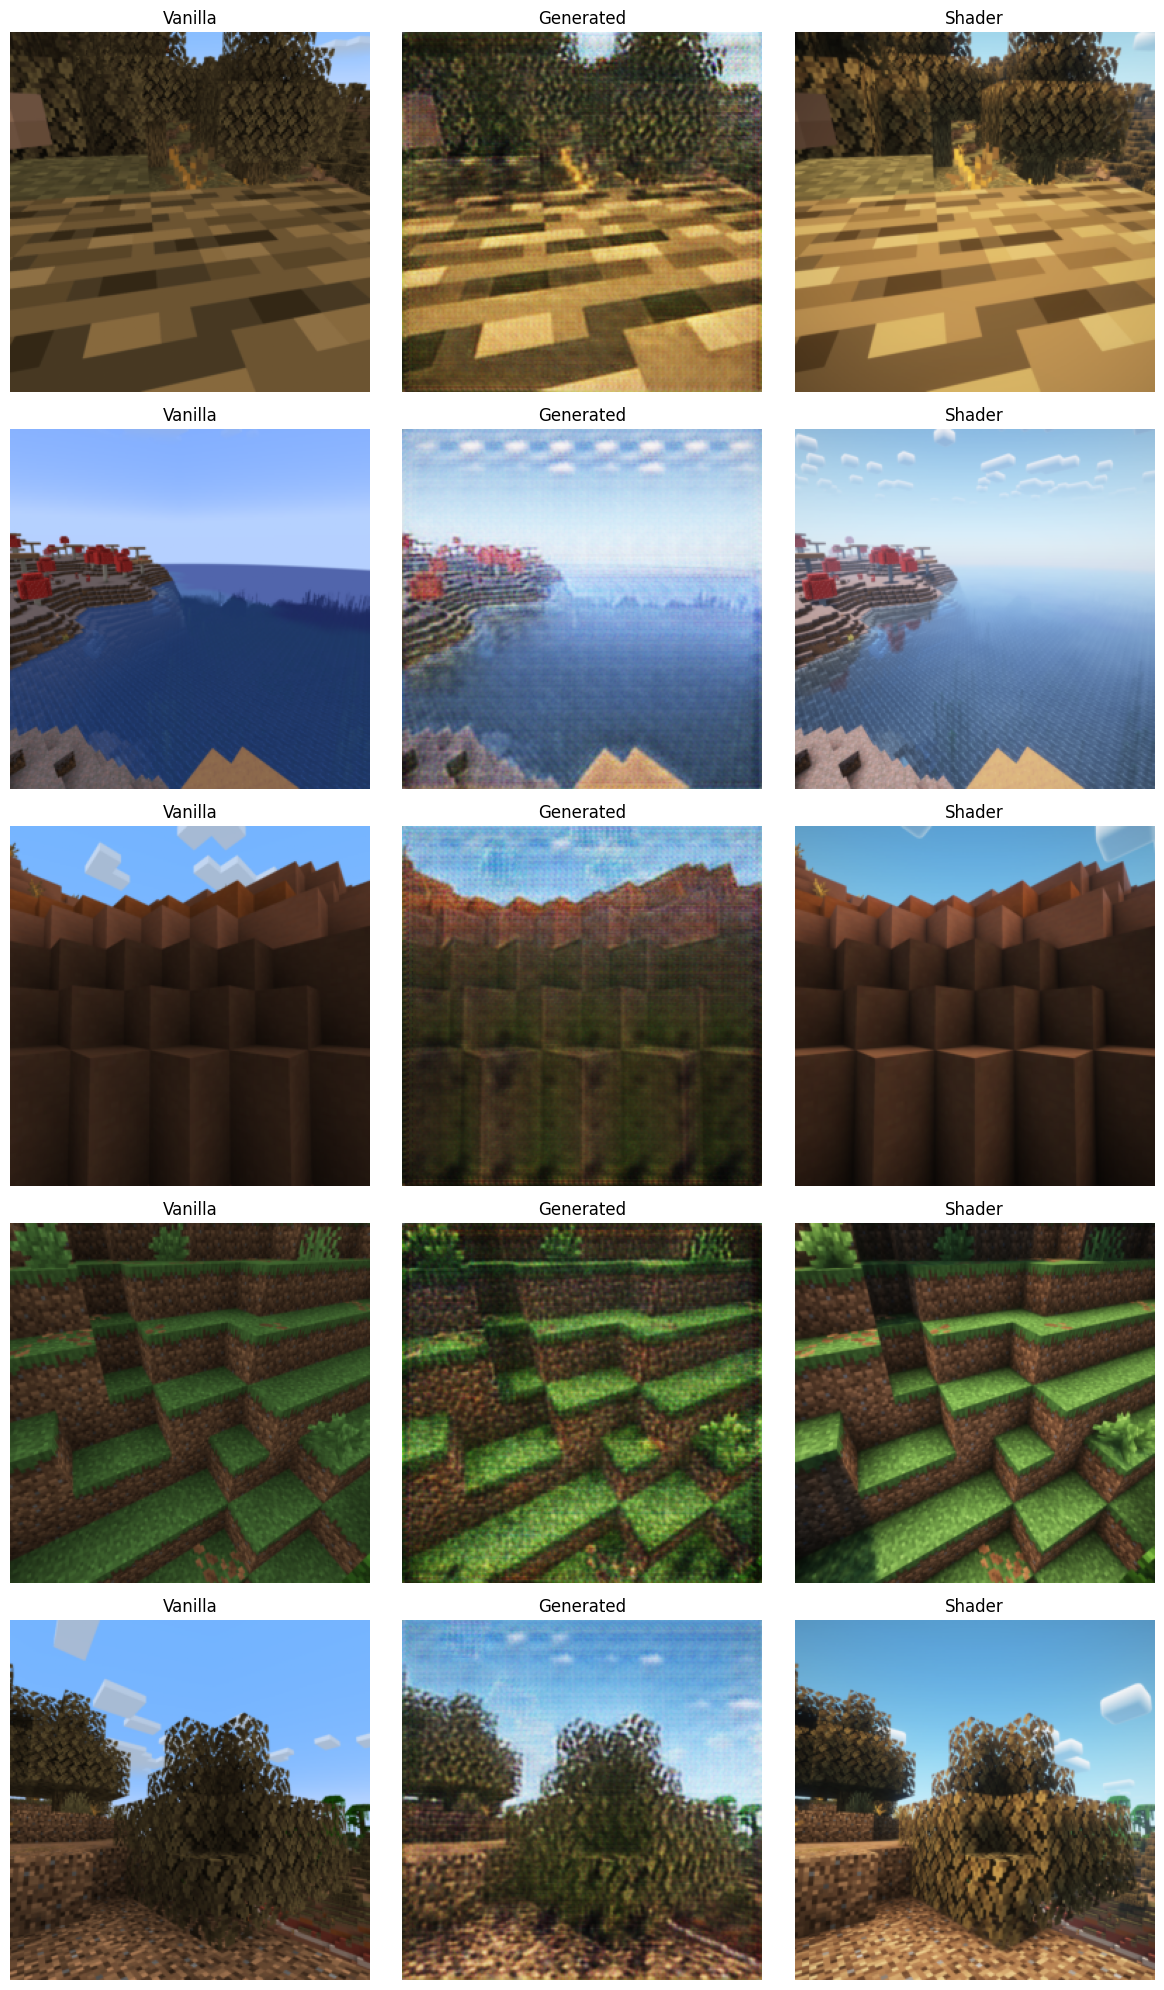

In [14]:
# Show results on test set
show_test_results(G, test_dl, device, num_samples=5)